In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os
from glob import glob
import cv2
import sklearn
import math

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
! kaggle datasets download -d hamzaboulahia/hardfakevsrealfaces

 78% 12.0M/15.3M [00:00<00:00, 122MB/s]
100% 15.3M/15.3M [00:00<00:00, 138MB/s]


In [ ]:
!mkdir data/
!unzip -qq hardfakevsrealfaces.zip 

In [ ]:
!wget http://www.robots.ox.ac.uk/~vgg/data/background_google/google_things.tar

--2022-11-07 09:35:48--  http://www.robots.ox.ac.uk/~vgg/data/background_google/google_things.tar
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/background_google/google_things.tar [following]
--2022-11-07 09:35:48--  https://www.robots.ox.ac.uk/~vgg/data/background_google/google_things.tar
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18872320 (18M) [application/x-tar]
Saving to: ‘google_things.tar’

google_things.tar   100%[===================>]  18.00M  14.1MB/s    in 1.3s    

2022-11-07 09:35:50 (14.1 MB/s) - ‘google_things.tar’ saved [18872320/18872320]



In [ ]:
!tar -xf google_things.tar
!mkdir data/0
!cp *.jpg data/0
!rm *jpg 
!mkdir data/1
!mv real/*.jpg data/1
!rm -r fake real 

In [ ]:
path_faces = glob('./data/1/*')
path_background = glob('./data/0/*')

In [ ]:
def load_images_from_folder(files):
    images = []
    for filename in files:
        img = cv2.imread(filename)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (24,24), interpolation = cv2.INTER_AREA)
        if resized is not None:
            images.append(resized)
    return np.array(images)

In [ ]:
face_images = load_images_from_folder(path_faces)
background_images = load_images_from_folder(path_background)


In [ ]:
face_images.shape

(589, 24, 24)

In [ ]:
background_images.shape

(520, 24, 24)

In [ ]:
y1 = np.ones(face_images.shape[0])
y0 = np.full(background_images.shape[0],-1)
Y = np.concatenate((y1,y0),axis=0)

In [ ]:
X = np.concatenate((face_images,background_images),axis=0)

In [ ]:
X.shape

(1109, 24, 24)

In [ ]:
Y.shape

(1109,)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

In [37]:
class DecisionStump(sklearn.base.BaseEstimator):
    def __init__(self):
        self.axis_ = 0  
        self.thres_ = 0.5  
        self.direction_ = 1  
        self.classes_ = np.array([-1, 1])  
        self.n_classes_ = 2  

    def fit(self, X, y, sample_weight=None):
        if sample_weight is None:
            sample_weight = np.ones((len(X),1))
        W = sample_weight.sum()  
        m = X.shape[0] # number of rows
        d = 24**2 * 4 # number of dimension
        self.classes_ = np.unique(y) # numero di classi, per il classificatore binario sono due
        W0 = sample_weight[np.where(y==self.classes_[0])[0]].sum()  
        minerr = W  
        for j in np.random.randint(size=d,low=0,high=24**4*4):
            values = project_samples(X,j)
            sorted_id = np.argsort(values)  
            x = values[sorted_id[0]] - 0.5  
            err = W0
            for i in range(m):
                if(i<m-1):
                    x = (values[sorted_id[i]]+values[sorted_id[i+1]])/2  
                else:
                    x = values[sorted_id[i]] + 0.5  
                if y[sorted_id[i]]==self.classes_[0]:
                    err = err-sample_weight[sorted_id[i]]
                else:
                    err = err+sample_weight[sorted_id[i]]
                if err<minerr:
                    self.axis_ = j
                    self.thres_ = x  
                    self.direction_ = 1
                    minerr = err
                if W-err<minerr:
                    self.axis_ = j
                    self.thres_ = x  
                    self.direction_ = -1
                    minerr = W-err
        return self
    def predict(self, X):
        values = project_samples(X,self.axis_)
        i = values[:]<=self.thres_  
        j = values[:]>self.thres_  
        p = self.classes_[0]*np.ones(len(X))  
        if self.direction_==1:
            p[j] = self.classes_[1]  
        else:
            p[i] = self.classes_[1]  
        return p  

def project_samples(X,d):
    dim = 24
    r = (d//4)%dim
    p = (d//(dim*4))%dim
    j = (d//(dim**2*4))%dim
    i = (d//(dim**3*4))%dim
    filter = d%4

    ret=[]

    for x in X:
        rettangolo = evaulate_rett([i,j],[p,r],x)

        if(filter==0):
            ret.append(first_mask(rettangolo))
        elif(filter==1):
            ret.append(second_mask(rettangolo))
        elif(filter==2):
            ret.append(third_mask(rettangolo))
        elif(filter==3):
            ret.append(fourth_mask(rettangolo))
    
    return np.array(ret)


def evaulate_rett(xs,ys,X):
    x_min=min(xs)
    x_max=max(xs)
    y_min=min(ys)
    y_max=max(ys)

    return X[x_min:x_max+1,y_min:y_max+1]


def first_mask(X):
    s1 = 0
    s2 = 0
    (m,n)=X.shape

    x_med =math.floor(n/2)


    for i in range(0,m):
        for j in range(0,n):
            if(j<=x_med):
                s1+=X[i,j]
            else:
                s2+=X[i,j]
    return s1-s2

def second_mask(X):
    s1 = 0
    s2 = 0
    (m,n)=X.shape

    x_med =math.floor(m/2)


    for i in range(0,m):
        for j in range(0,n):
            if(i<=x_med):
                s1+=X[i,j]
            else:
                s2+=X[i,j]
    return s1-s2


def third_mask(X):
    s1 = 0
    s2 = 0
    (m,n)=X.shape

    x_1 =math.floor(n/3)
    x_2 = x_1*2



    for i in range(0,m):
        for j in range(0,n):
            if(j<=x_1 or j>x_2):
                s1+=X[i,j]
            else:
                s2+=X[i,j]
    return s1-s2


def fourth_mask(X):
    s1 = 0
    s2 = 0
    (m,n)=X.shape

    x_n =math.floor(n/2)
    x_m = math.floor(m/2)


    for i in range(0,m):
        for j in range(0,n):
            if(i<=x_m and j<=x_n or i>x_m and j>x_n):
                s2+=X[i,j]
            else:
                s1+=X[i,j]
    return s1-s2

In [38]:
ne = 50

In [39]:
import sklearn.ensemble as ske

ada_clf = ske.AdaBoostClassifier(DecisionStump(),n_estimators=ne, algorithm='SAMME')

In [ ]:
ada_clf.fit(X_train,y_train)

In [41]:
y_pred = ada_clf.predict(X_test)

In [42]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test,y_pred)

array([[ 91,   6],
       [  5, 120]])

In [43]:
error_imgs = X_test[np.where(y_test==y_pred)]

In [25]:
import pickle
filename="VJ_adaboost.sav"
pickle.dump(ada_clf, open(filename, 'wb'))

#loaded_model = pickle.load(open(filename, 'rb'))

In [45]:
ada_clf.score(X_test,y_test)

0.9504504504504504

In [54]:
def draw(X,i,j):

    X[i,j:j+24]=255
    X[i+24,j:j+24]=255
    X[i:i+24,j]=255
    X[i:i+24,j+24]=255

In [69]:
def find_faces(X):
  X_gray = cv2.cvtColor(X, cv2.COLOR_BGR2GRAY)
  X_out = cv2.cvtColor(X, cv2.COLOR_BGR2GRAY)
  (m,d)=X_gray.shape
  step = 10
  c = 0
  for i in range(0,m-24,step):
    for j in range(0,d-24,step):
      img = evaulate_rett([i,i+23],[j,j+23],X_gray)
      if(not img.shape == (24,24)):
        continue
      res = ada_clf.predict([img])
      if res[0]==1:
        #cv2_imshow(cv2.resize(img,(256,256),interpolation = cv2.INTER_AREA))
        draw(X_out,i,j)

      else:
        c+=1
  print(c)
  cv2_imshow(X_out)

In [28]:
!wget "https://www4.unfccc.int/sites/NWPStaging/PublishingImages/IPP%20multistakeholder%20dialogue%20participants%20May%202017.jpg"

--2022-11-07 14:13:12--  https://www4.unfccc.int/sites/NWPStaging/PublishingImages/IPP%20multistakeholder%20dialogue%20participants%20May%202017.jpg
Resolving www4.unfccc.int (www4.unfccc.int)... 45.60.45.230
Connecting to www4.unfccc.int (www4.unfccc.int)|45.60.45.230|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 215719 (211K) [image/jpeg]
Saving to: ‘IPP multistakeholder dialogue participants May 2017.jpg’

IPP multistakeholde 100%[===================>] 210.66K   522KB/s    in 0.4s    

2022-11-07 14:13:13 (522 KB/s) - ‘IPP multistakeholder dialogue participants May 2017.jpg’ saved [215719/215719]



In [29]:
filename=glob("./*.jpg")

In [30]:
filename

['./IPP multistakeholder dialogue participants May 2017.jpg']

In [49]:
img = cv2.imread(filename[0])

In [61]:
img.shape

(475, 940, 3)

1282


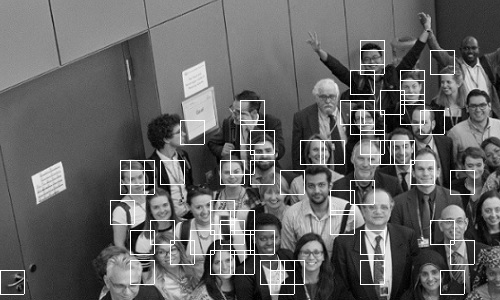

In [70]:
find_faces(img[0:300,0:500,:])

Better result can be achieved by adding more samples in the training set. 